Final Cleaned Dataset Shape: (150327, 12)

Correlation Matrix saved to 'correlation_matrix.png'
*** Linear Regression Results: ***
R² Score: 0.6300
RMSE: 2.2603

*** Random Forest Regression Results: ***
R² Score: 0.6376
RMSE: 2.2368



(0.6376184672408021, 2.236822013004823)

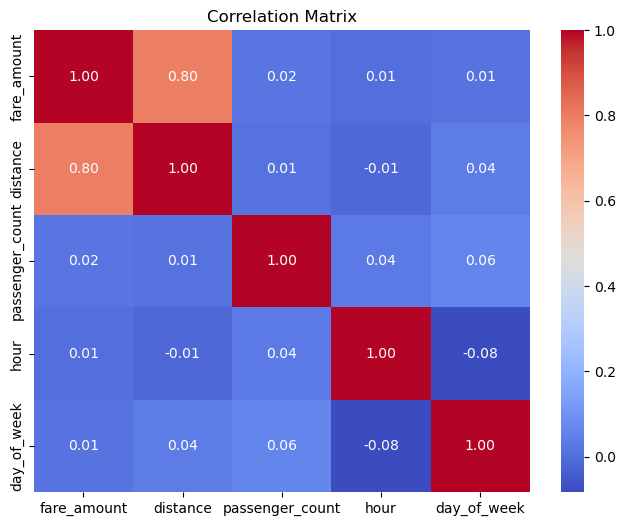

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# --- 1. Utility Functions ---

# Earth's radius in km
R = 6371

def haversine(lat1, lon1, lat2, lon2):
    """Calculates the distance in km between two lat/lon points."""
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def handle_outliers_iqr(df, column, factor=1.5):
    """Filters outliers using the 1.5 * IQR method."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

def evaluate_model(y_true, y_pred, name):
    """Calculates and prints R2 and RMSE scores."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"*** {name} Results: ***")
    print(f"R² Score: {r2:.4f}") 
    print(f"RMSE: {rmse:.4f}\n")
    return r2, rmse

# --- 2. Data Pre-processing and Feature Engineering ---
# NOTE: The notebook used a hardcoded path. Using the file name is best practice.
df = pd.read_csv("D:/ML/archive/uber.csv")

# Initial cleaning and feature conversion
df = df.dropna()
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Feature Engineering
df['distance'] = haversine(
    df['pickup_latitude'], df['pickup_longitude'],
    df['dropoff_latitude'], df['dropoff_longitude']
)
df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek

# Outlier Handling (Using IQR method as in your provided code)
df = handle_outliers_iqr(df, 'fare_amount')
df = handle_outliers_iqr(df, 'distance')
df = handle_outliers_iqr(df, 'passenger_count')

# Remove impossible values
df = df[df['fare_amount'] > 0]
df = df[df['distance'] > 0]
print(f"Final Cleaned Dataset Shape: {df.shape}\n")


# --- 3. Correlation Check (Visualization) ---
features_for_corr = ['fare_amount', 'distance', 'passenger_count', 'hour', 'day_of_week']
corr = df[features_for_corr].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png') # Save plot instead of showing
print("Correlation Matrix saved to 'correlation_matrix.png'") # Notify user of the saved file
# fileTag: correlation_matrix.png


# --- 4. Model Setup and Training ---

# Define features and target
X = df[['distance', 'passenger_count', 'hour', 'day_of_week']]
y = df['fare_amount']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling for Linear Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# A. Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
evaluate_model(y_test, y_pred_lr, "Linear Regression")

# B. Random Forest Regression
# Using n_jobs=-1 to speed up training
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15)
rf.fit(X_train, y_train) 
y_pred_rf = rf.predict(X_test)
evaluate_model(y_test, y_pred_rf, "Random Forest Regression")